# 20211012-base-simpoints
Evaluate IPCs, accuracy, and coverage over individual simpoints for the base prefetchers, on one trace.

In [1]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt
from IPython.display import display

from utils.load import load_simpoint_weights, parse_champsim_result_file, load_champsim_base_results, parse_paper_result_file

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [2]:
traces = [
    '473.astar',
    '471.omnetpp',
    '429.mcf',
    '450.soplex',
    '482.sphinx3',
]


simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/base-prefetch1-fixedcache-500m/'
max_instruction_num = 500 # in millions
min_instruction_interval = 0 # in millions (this does not affect IPC results much)
verbose = True

---
# Load simpoint weights and results.

In [3]:
simpoint_weights = {}
for tr in traces:
    simpoint_weights[tr] = load_simpoint_weights(simpoints_dir, tr)

if verbose:
    print('Simpoint weights:')
    for tr in traces:
        print(f'{tr:12} : {simpoint_weights[tr]} largest = s{simpoint_weights[tr].argmax()}') # Why don't mcf weights add to 100?

Simpoint weights:
473.astar    : [0.452174 0.162319 0.22029 ] largest = s0
471.omnetpp  : [0.0309654 0.954463  0.010929 ] largest = s1
429.mcf      : [0.154639 0.175258 0.329897] largest = s2
450.soplex   : [0.185976 0.164634 0.347561] largest = s2
482.sphinx3  : [0.175692 0.222623 0.135078] largest = s1


In [4]:
results = {}
for tr in traces:
    base_data = []
    for i in range(len(simpoint_weights[tr])):
        base_data.append(load_champsim_base_results(
            results_dir, f'{tr}-s{i}', 
            max_instruction_num=max_instruction_num * 1000000,
            min_instruction_interval=int(min_instruction_interval * 1000000),
            verbose=verbose
        ))
    results[tr] = base_data

Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s1*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*473.astar-s2*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s1*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*471.omnetpp-s2*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*429.mcf-s0*.txt
    Found variations: BO NoPrefetcher ISB ISB+BO
Loading results from: data/base-prefetch1-fixedcache-500m/*429.mcf-s1*.txt
    Found variations: BO NoPrefetcher I

---
# Plotting / table helpers

**TODO** Break out into a utils file

In [5]:
def plot_simpoint_results(data, title, y_label, 
                          subtitle=None, factor = 1., ymin=None, ymax=None,
                          simpoint_weights=None):
    """Plot **per-simpoint** data for a
    list of prefetchers, on one trace.
    """
    fig, ax = plt.subplots(dpi=128)
    num_simpoints = len(data[list(data.keys())[0]])
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    step_size = 0.1
    width = 0.075
    
    for i in range(num_simpoints):
        ax.bar(i, data['BO'][i] * factor, 
               color='C0', width = width, 
               label='BO' if i == 0 else ''
        )
        ax.bar(i + step_size, data['ISB'][i] * factor, 
               color='C1', width=width, 
               label='ISB' if i == 0 else ''
        )
        ax.bar(i + 2*step_size, data['ISB+BO'][i] * factor, 
               color='C2', width=width, 
               label='ISB + BO' if i == 0 else ''
        )

    ax.legend()
    tick_locs = [i + 0.1 for i in range(0, num_simpoints)]
    tick_labels = [f's{i}' for i in range(0, num_simpoints)]
    if simpoint_weights is not None:
        for i, w in enumerate(simpoint_weights):
            tick_labels[i] += f' ({w:.3f})'

    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels)
    
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin=ymin, ymax=ymax)

In [6]:
def df_simpoint_results(data, pop=[], factor=1.):
    data_ = {}
    for k in data.keys():
        data_[k] = [round(v * factor, 2) for v in data[k]]
    df = pd.DataFrame.from_dict(data_)
    df = df.drop(labels=pop, axis=1)
    return df

# IPC measurements
IPC = Instructions per cycle

In [7]:
def get_simpoint_ipcs(results):
    """Parse the results dictionary to get an array
    of simpoint IPCs for each prefetcher. For prefetcher 
    p, simpoint_ipcs[p][i] is thstatisticse cumulative IPC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_ipcs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_ipcs[pf][spidx] = sp[pf].cumulative_ipcs[-1] 
    return simpoint_ipcs

In [8]:
simpoint_ipcs = {}
for tr in traces:
    simpoint_ipcs[tr] = get_simpoint_ipcs(results[tr])
simpoint_ipcs

{'473.astar': defaultdict(<function __main__.get_simpoint_ipcs.<locals>.<lambda>()>,
             {'BO': array([1.0578  , 0.477799, 0.116522], dtype=float32),
              'NoPrefetcher': array([1.0578  , 0.476514, 0.115082], dtype=float32),
              'ISB': array([1.15546 , 0.501984, 0.162398], dtype=float32),
              'ISB+BO': array([1.15546 , 0.502212, 0.162402], dtype=float32)}),
 '471.omnetpp': defaultdict(<function __main__.get_simpoint_ipcs.<locals>.<lambda>()>,
             {'BO': array([0.55542 , 0.294229, 0.443991], dtype=float32),
              'NoPrefetcher': array([0.555424, 0.283863, 0.443978], dtype=float32),
              'ISB': array([0.591312, 0.418568, 0.45925 ], dtype=float32),
              'ISB+BO': array([0.591332, 0.41983 , 0.460241], dtype=float32)}),
 '429.mcf': defaultdict(<function __main__.get_simpoint_ipcs.<locals>.<lambda>()>,
             {'BO': array([0.0804487, 0.0800712, 0.0991509], dtype=float32),
              'NoPrefetcher': array([0.080

#### Cumulative IPCs

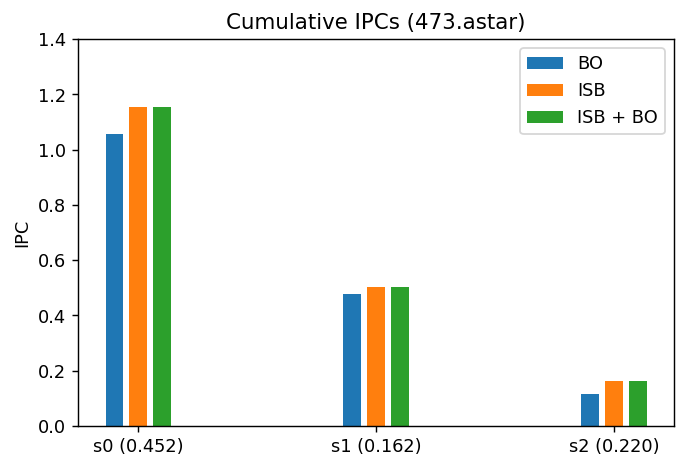

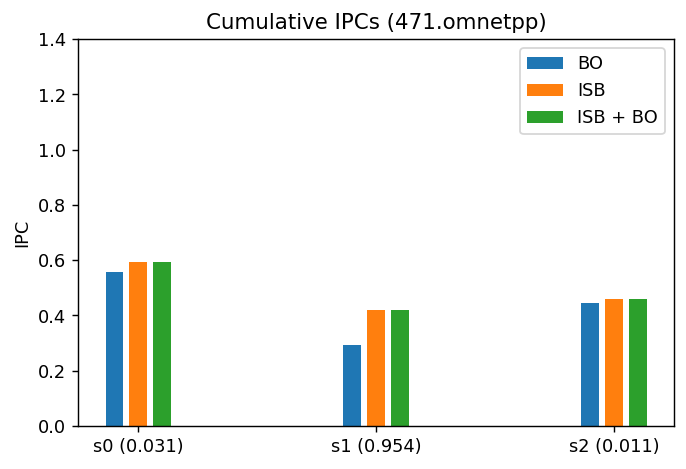

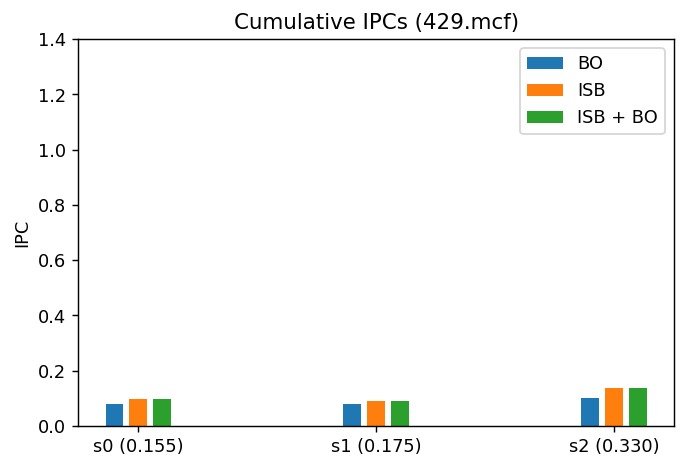

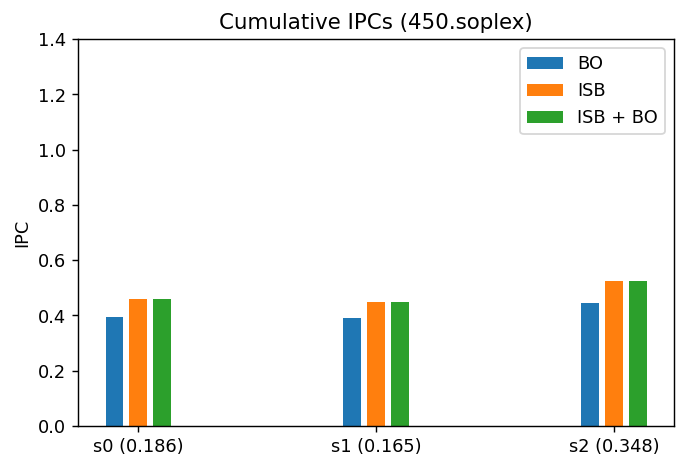

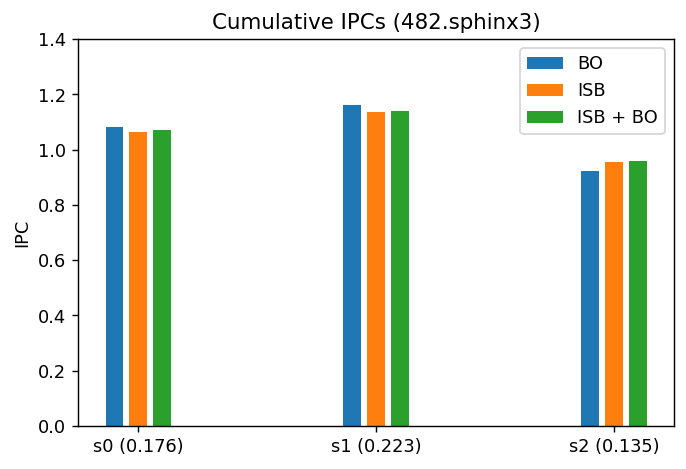

In [9]:
for tr in traces:
    plot_simpoint_results(
        simpoint_ipcs[tr], 'Cumulative IPCs', 'IPC',
        subtitle=tr,
        simpoint_weights=simpoint_weights[tr],
        ymax=1.4
    )

In [10]:
for tr in traces:
    print(f'======== {tr:12} =========')
    display(df_simpoint_results(simpoint_ipcs[tr]))

======== 473.astar    =========


,BO,NoPrefetcher,ISB,ISB+BO
0,1.06,1.06,1.16,1.16
1,0.48,0.48,0.50,0.50
2,0.12,0.12,0.16,0.16


======== 471.omnetpp  =========


,BO,NoPrefetcher,ISB,ISB+BO
0,0.56,0.56,0.59,0.59
1,0.29,0.28,0.42,0.42
2,0.44,0.44,0.46,0.46


======== 429.mcf      =========


,BO,NoPrefetcher,ISB,ISB+BO
0,0.08,0.08,0.10,0.10
1,0.08,0.08,0.09,0.09
2,0.10,0.10,0.14,0.14


======== 450.soplex   =========


,BO,NoPrefetcher,ISB,ISB+BO
0,0.39,0.34,0.46,0.46
1,0.39,0.33,0.45,0.45
2,0.44,0.38,0.52,0.52


======== 482.sphinx3  =========


,BO,NoPrefetcher,ISB,ISB+BO
0,1.08,0.65,1.07,1.07
1,1.16,0.70,1.14,1.14
2,0.92,0.58,0.96,0.96


---
# Accuracy measurements
Accuracy = useful / (useful + useless) prefetches

In [11]:
def get_simpoint_accuracies(results):
    """Parse the results dictionary to get an array
    of simpoint accuracies for each prefetcher. For prefetcher 
    p, simpoint_accs[p][i] is the accuracy of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_accs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_accs[pf][spidx] = sp[pf].accuracy
    return simpoint_accs

In [12]:
simpoint_accs = {}
for tr in traces:
    simpoint_accs[tr] = get_simpoint_accuracies(results[tr])

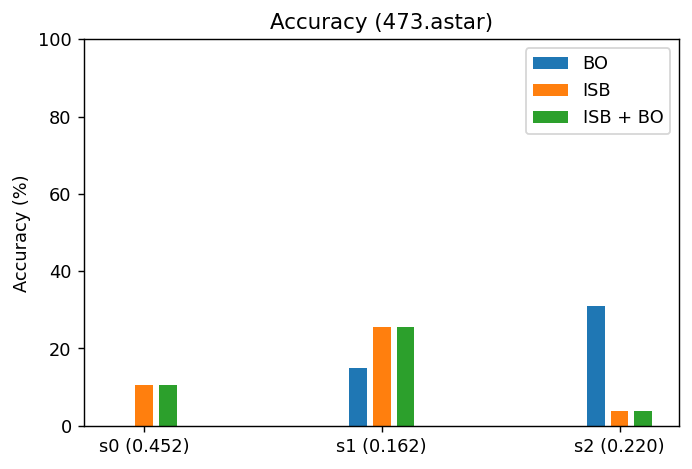

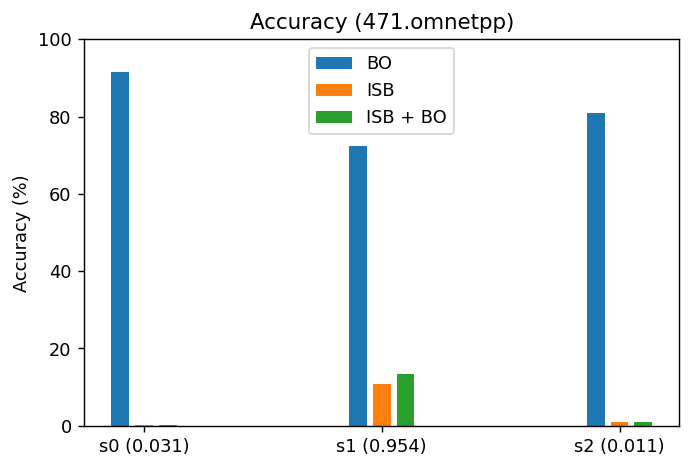

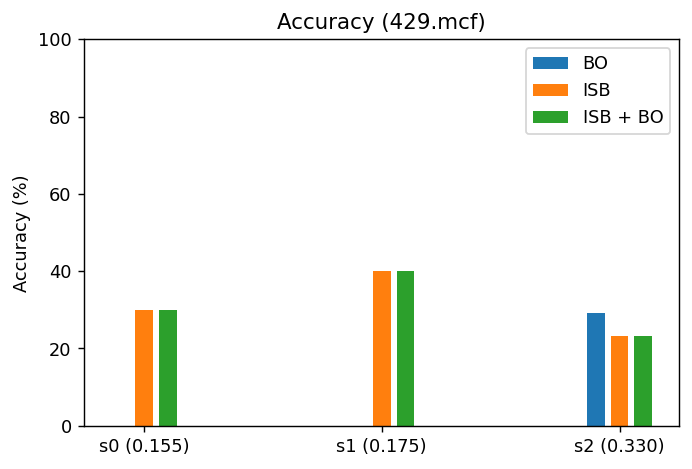

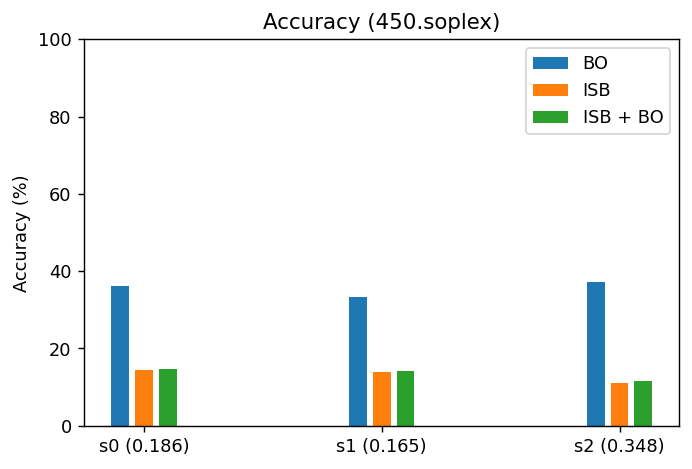

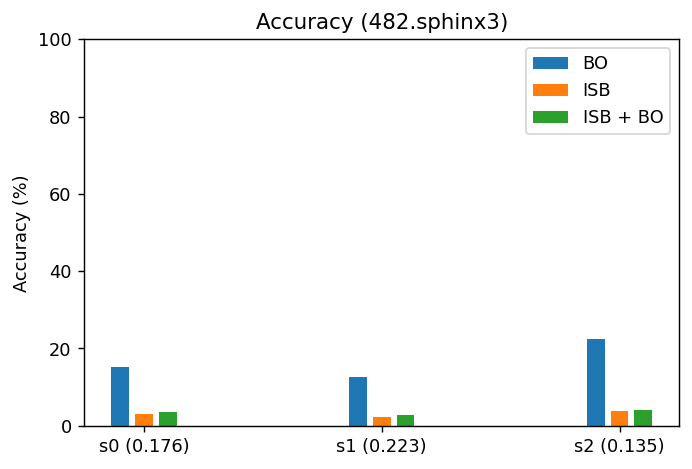

In [13]:
for tr in traces:
    plot_simpoint_results(
        simpoint_accs[tr], 'Accuracy', 'Accuracy (%)', 
        subtitle=tr,
        factor=100,
        ymin=0, ymax=100,
        simpoint_weights=simpoint_weights[tr]
    )

In [14]:
for tr in traces:
    print(f'======== {tr:12} =========')
    display(df_simpoint_results(simpoint_accs[tr], factor=100, pop=['NoPrefetcher']))

======== 473.astar    =========


,BO,ISB,ISB+BO
0,0.00,10.58,10.58
1,14.97,25.67,25.65
2,30.98,3.91,3.94


======== 471.omnetpp  =========


,BO,ISB,ISB+BO
0,91.48,0.15,0.19
1,72.47,10.83,13.30
2,80.83,0.96,0.92


======== 429.mcf      =========


,BO,ISB,ISB+BO
0,0.00,29.98,29.97
1,0.00,40.05,40.04
2,29.22,23.18,23.16


======== 450.soplex   =========


,BO,ISB,ISB+BO
0,36.14,14.47,14.60
1,33.39,13.84,14.11
2,37.11,11.10,11.53


======== 482.sphinx3  =========


,BO,ISB,ISB+BO
0,15.32,2.94,3.47
1,12.65,2.27,2.83
2,22.55,3.69,4.18


---
# Coverage measurements
Coverage = Percent increase of:
- \# of LLC load + RFO hits on a prefetcher
- vs. # of LLC load + RFO hits on baseline (NoPrefetcher)

In [15]:
def get_simpoint_coverages(results, baseline_prefetcher='NoPrefetcher'):
    """Parse the results dictionary to get an array
    of simpoint coverages for each prefetcher. For prefetcher 
    p, simpoint_covs[p][i] is the co471.omnetppverage of p on
    simpoint s_i w.r.t. the baseline.
    """
    num_simpoints = len(results)
    simpoint_covs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        base_hits = sp[baseline_prefetcher].llc_load_hits + sp[baseline_prefetcher].llc_rfo_hits
        
        #print(spidx)
        for pf in sp:
            #if pf == baseline_prefetcher:
            #    continue
            
            pf_hits = sp[pf].llc_load_hits + sp[pf].llc_rfo_hits
            
            
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_covs[pf][spidx] = (pf_hits - base_hits) / base_hits
            
            #print(pf, base_hits, pf_hits, simpoint_covs[pf][spidx])
    return simpoint_covs

In [16]:
simpoint_covs = {}
for tr in traces:
    simpoint_covs[tr] = get_simpoint_coverages(results[tr])

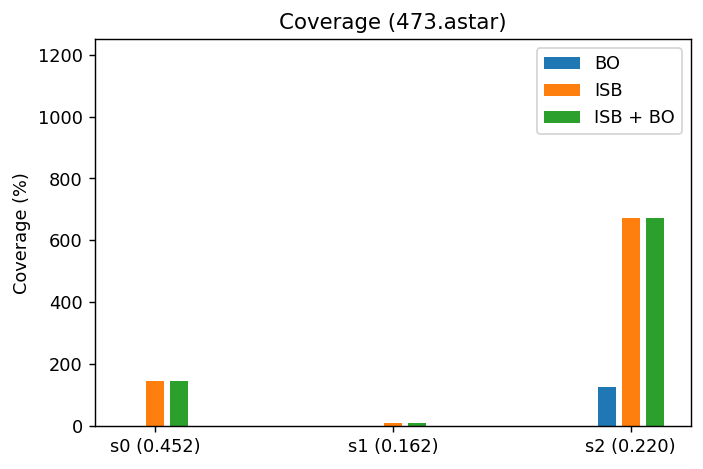

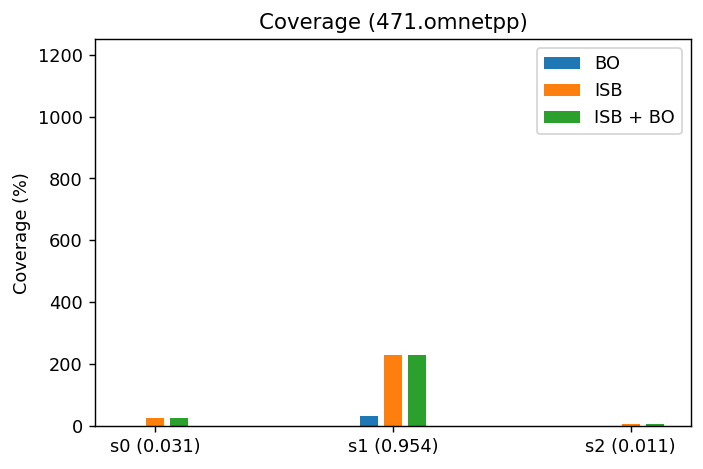

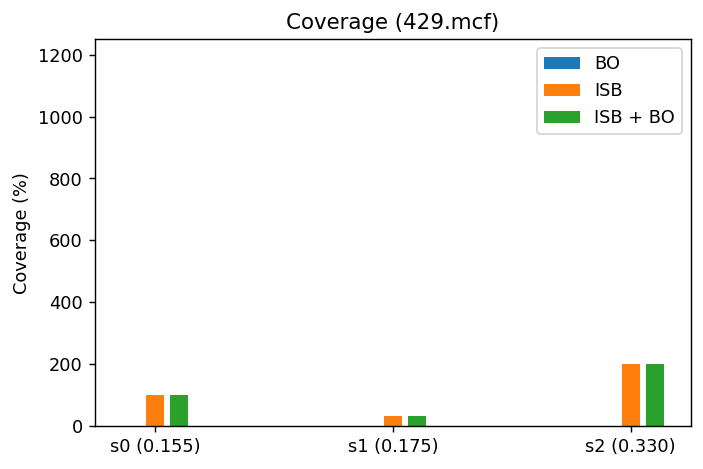

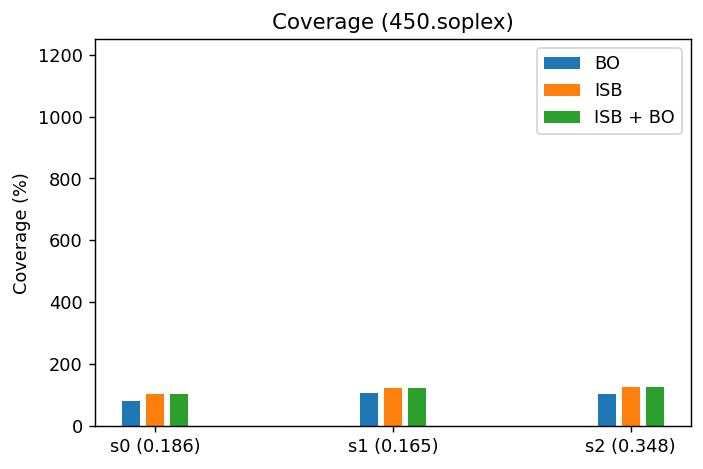

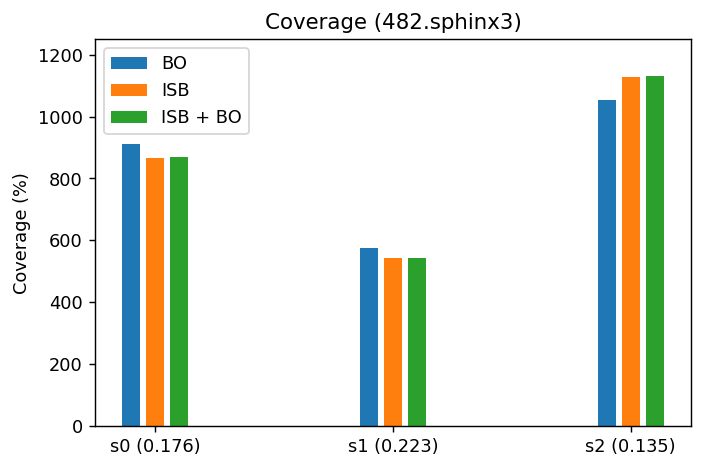

In [17]:
for tr in traces:
    plot_simpoint_results(
        simpoint_covs[tr], 'Coverage', 'Coverage (%)',
        subtitle=tr,
        factor=100,
        ymin=0, ymax=1250,
        simpoint_weights=simpoint_weights[tr]
    )

In [18]:
for tr in traces:
    print(f'======== {tr:12} =========')
    display(df_simpoint_results(simpoint_covs[tr], factor=100, pop=['NoPrefetcher']))

======== 473.astar    =========


,BO,ISB,ISB+BO
0,0.00,145.13,145.13
1,0.41,8.64,8.70
2,124.37,671.61,671.63


======== 471.omnetpp  =========


,BO,ISB,ISB+BO
0,-0.13,24.92,24.92
1,32.10,227.20,228.99
2,-4.74,5.97,6.53


======== 429.mcf      =========


,BO,ISB,ISB+BO
0,0.00,99.21,99.27
1,0.00,31.30,31.31
2,0.02,199.52,199.81


======== 450.soplex   =========


,BO,ISB,ISB+BO
0,79.45,101.93,103.53
1,106.25,121.52,122.05
2,101.86,125.40,126.55


======== 482.sphinx3  =========


,BO,ISB,ISB+BO
0,909.84,865.74,869.30
1,576.21,541.58,542.70
2,1053.28,1126.16,1131.88


---
# Unified accuracy/coverage

In [19]:
def get_simpoint_uacs(results):
    """Parse the results dictionary to get an array
    of simpoint UACs for each prefetcher. For prefetcher 
    p, simpoint_uacs[p][i] is the UAC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_uacs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_uacs[pf][spidx] = sp[pf].uac
    return simpoint_uacs

In [20]:
simpoint_uacs = {}
for tr in traces:
    simpoint_uacs[tr] = get_simpoint_uacs(results[tr])

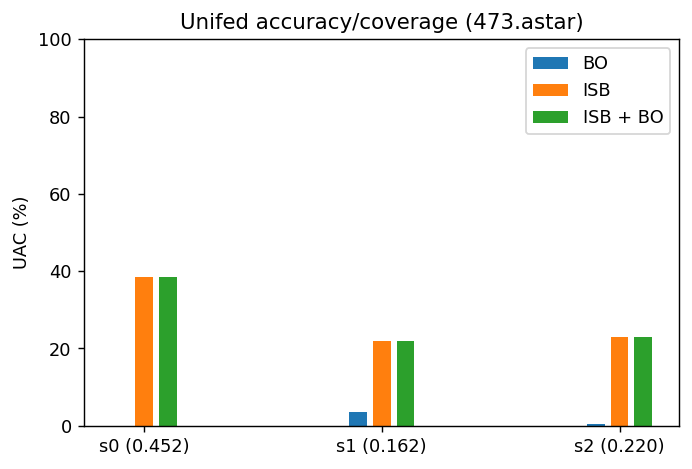

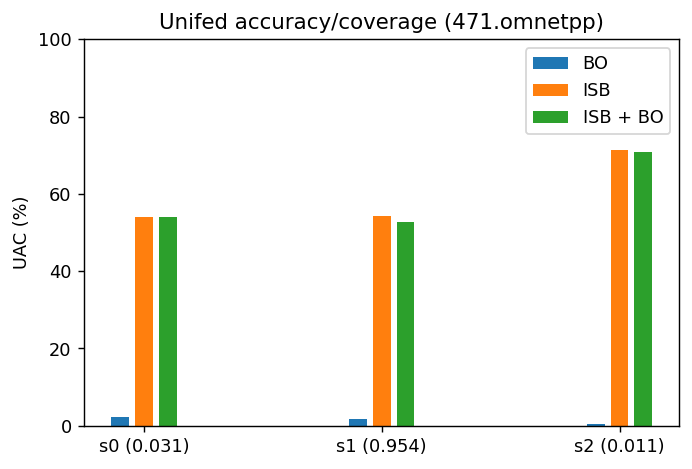

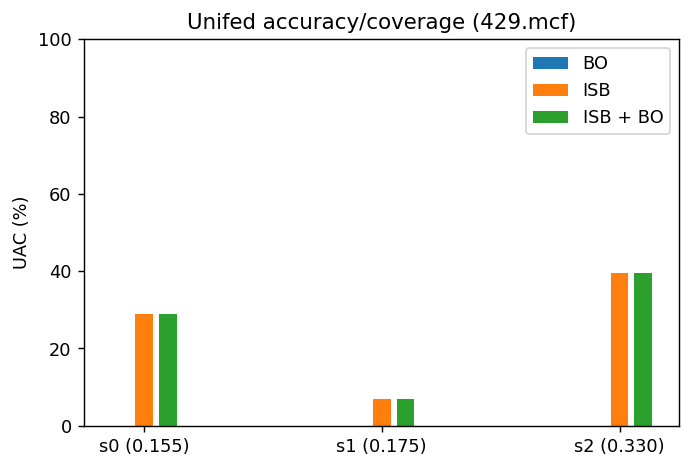

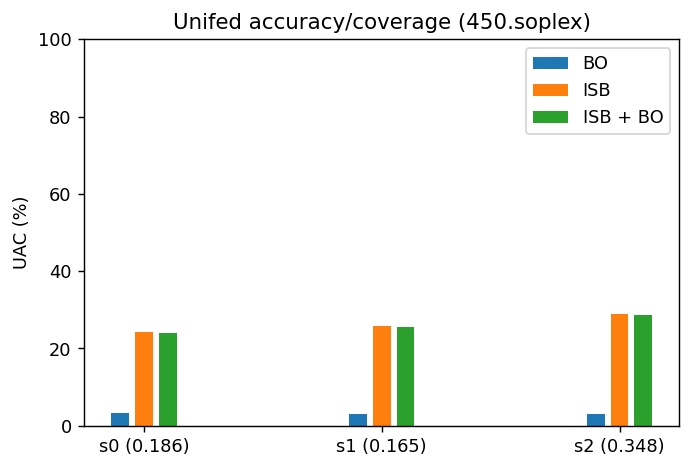

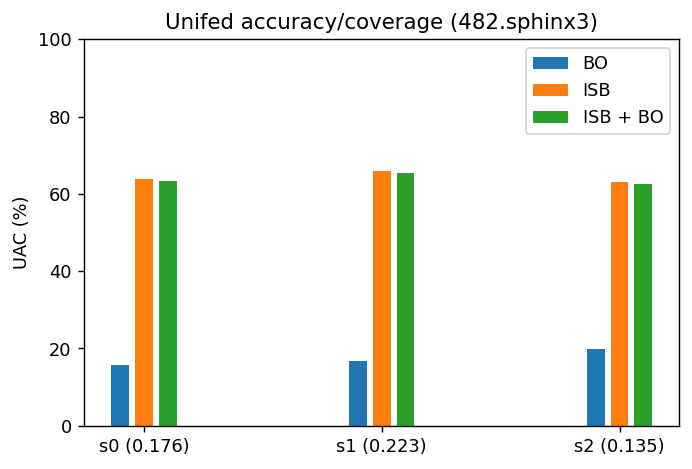

In [21]:
for tr in traces:
    plot_simpoint_results(
        simpoint_uacs[tr], 'Unifed accuracy/coverage', 'UAC (%)',
        subtitle=tr,
        factor=100,
        ymin=0, ymax=100,
        simpoint_weights=simpoint_weights[tr]
    )

In [22]:
for tr in traces:
    print(f'======== {tr:12} =========')
    display(df_simpoint_results(simpoint_uacs[tr], factor=100, pop=['NoPrefetcher']))

======== 473.astar    =========


,BO,ISB,ISB+BO
0,0.00,38.50,38.50
1,3.62,21.93,21.91
2,0.48,22.99,22.98


======== 471.omnetpp  =========


,BO,ISB,ISB+BO
0,2.37,54.12,54.11
1,1.82,54.32,52.67
2,0.56,71.44,70.92


======== 429.mcf      =========


,BO,ISB,ISB+BO
0,0.0,28.84,28.84
1,0.0,7.01,7.01
2,0.0,39.56,39.53


======== 450.soplex   =========


,BO,ISB,ISB+BO
0,3.29,24.30,24.04
1,3.13,25.73,25.61
2,2.93,28.92,28.68


======== 482.sphinx3  =========


,BO,ISB,ISB+BO
0,15.75,63.84,63.30
1,16.86,65.94,65.42
2,19.86,63.07,62.54
